#Clasificación de datos por el método de Kernel Density Estimation




En este trabajo se implementa un algoritmo de clasificación de datos de señales electroencefalográficas (EEG) por el método de Kernel Density Estimation (KDE) utilizando un kernel Gaussiano.

Las señales EEG presentan formas muy complejas por lo que no es simple definir un criterio para distinguirlas.
Anteriormente se analizó una base datos que contiene señales EEG de imagenes motoras de dos estimulos y la linea base. LOs estimulos son, movimiento de mano derecha (RH), movimiento de mano izquierda(LH) y neurtro (N). 

De acuerdo al analisis realizado, se determinó que dentro de los 14 canales que forman una señal de EEG. el canal con la mayor probabilidad de ser distinguible es el "Fp1" y asi mismo las frencuencias más distinguibles de la señal son de baja frecuencia, "5 Hz", "6 Hz" y "7 Hz".
Partiendo del análisis previo, a continuación se implementa un clasificador pro medio del algoritmo KDE sabiendo que se utilizaran los datos de las frecuencias "5 Hz", "6 Hz" y "7 Hz" del canal "Fp1". 

Se importan las librerias de Python.

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as geek
import pandas as pd
from scipy.stats import mannwhitneyu,wilcoxon
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
import sys
from __future__ import division
import operator
import random
from random import sample
from sklearn.cluster import KMeans
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import statistics as sts

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


TIMEOUT: ignored

Se preparan los datos contenidos en el archivo. 

In [ ]:
def enumerarEtiquetas(etiquetas):
  #lista=['0']*(etiquetas.size)
  lista=[0]*(etiquetas.size)
  lista2=['Nulo']*(etiquetas.size)
  lista3=['Nulo']*(etiquetas.size)
  etiqVec=[None]*5
  for i in range(1,4):
    etiqVec[i]=(etiquetas==i)*1
    vectorRotado=np.roll(etiqVec[i],-1)
    vectordeCambios=vectorRotado-etiqVec[i]
    inicio=np.where(vectordeCambios==1)
    fin=np.where(vectordeCambios==-1)
    start=inicio[0]+1
    end=fin[0]+1
    if i==3:
        cadena2='WM'
    if i==2:
        cadena2='RH'
    if i==1:
        cadena2='LH'

    for indice in range(0,start.size):
        for j in range(start[indice],end[indice]):
            #cadena=str(i)+"-"+str(indice)
            #lista[j]=cadena
            lista[j]=indice
            lista2[j]=cadena2
  return np.array(lista),np.array(lista2)


Se ordenan los datos en un DataFrame para procesarlos. 

In [ ]:

direccion='/content/drive/My Drive/Colab Notebooks/'+'CLASubjectA1601083StLRHand.mat'

mat=loadmat(direccion)   #load mat-file
datos=mat['o']['data'][0,0]
etiquetas=mat['o']['marker'][0,0]
canales=['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','A1','A2','F7','F8','T3',
                                     'T4','T5','T6','Fz','Cz','Pz','X5']
puntos=200
frequency=mat['o']['sampFreq'][0,0]
nuevasEtiquetas,estimulos=enumerarEtiquetas(etiquetas)
df_datos=pd.DataFrame(datos,columns=canales)
df_etiquetas=pd.DataFrame(nuevasEtiquetas,columns=['Etiquetas'])
df_estimulos=pd.DataFrame(estimulos,columns=['Estimulos'])
df =pd.concat([df_estimulos,df_etiquetas,df_datos],axis=1)

columns_features=['features']+canales
featuresDF=pd.DataFrame(columns=columns_features)

estimulosAgrupados= df.groupby(['Estimulos'])
RH=estimulosAgrupados.get_group('RH')
WM=estimulosAgrupados.get_group('WM')
LH=estimulosAgrupados.get_group('LH')
    
RH_Data=RH.groupby(['Etiquetas'])
WM_Data=WM.groupby(['Etiquetas'])
LH_Data=LH.groupby(['Etiquetas'])




La siguiente función obtiene los datos de training y de test de cada uno de los estimulos. 

In [ ]:
def Data(chanel,freq):
  global RH_Data
  global WM_Data
  global LH_Data
  global puntos

  NumRealizaciones=LH_Data.ngroups
  trainingDataNumber=round(0.7*NumRealizaciones)
  testDataNumber=round(0.3*NumRealizaciones)
  
  L=sample(range(0,NumRealizaciones),NumRealizaciones)
  vectorTrainingData=L[0:trainingDataNumber]
  vectorTestData=L[trainingDataNumber:NumRealizaciones]
  vectorData=[]
  labels=[]
  vectorD=[]
  lbs=[]

  Uc=3

  for i in range(0,NumRealizaciones):
    SignalsRH=RH_Data.get_group(i).iloc[:,2:]
    SignalsLH=LH_Data.get_group(i).iloc[:,2:]
    SignalsN=WM_Data.get_group(i).iloc[:,2:]
    x=SignalsRH[chanel][0:puntos]
    y=SignalsLH[chanel][0:puntos]
    z=SignalsN[chanel][0:puntos]
    TFx=2/puntos*np.abs(np.fft.fft(x))
    TFy=2/puntos*np.abs(np.fft.fft(y))
    TFz=2/puntos*np.abs(np.fft.fft(z))
    Cfx=TFx[freq]
    Cfy=TFy[freq]
    Cfz=TFz[freq]

    vectorData.append([Cfx])
    labels.append(0)  
    vectorData.append([Cfy])
    labels.append(1)     
    vectorData.append([Cfz])
    labels.append(2)

    for i in range(0,len(vectorData)):
      if vectorData[i][0]>Uc:
       vectorD.append(vectorData[i])
       lbs.append(labels[i])

  return vectorD,lbs


class GaussianClassifier:
  """Clasificador Gaussiano"""


  """Calculo de media y varianza de cada conjunto de datos"""
  def getParameters(self,X,y,st):
    v=[]
    for i in range(0,len(y)):
      if y[i]==st:
        v.append(X[i])
    v=np.array(v)
    return v.mean(),v.var()


  def train(self,X,y):
    """Media y covarianza de las clases"""
    self.mean_N,self.var_N=self.getParameters(X,y,0)
    self.mean_RH,self.var_RH=self.getParameters(X,y,1)
    self.mean_LH,self.var_LH=self.getParameters(X,y,2)

    """Probabilidad a priori"""
    self.p_N=y.count(0)/len(y)
    self.p_RH=y.count(1)/len(y)
    self.p_LH=y.count(2)/len(y)

    self.prob_N = norm(self.mean_N,self.var_N)
    self.prob_RH = norm(self.mean_RH,self.var_RH)
    self.prob_LH = norm(self.mean_LH,self.var_LH)
    
  def predict(self,X):
    """Probabilidad a posterior"""
    preds=[]
    p=[0]*3
    preds=[]
    for x in X:
      x=x[0]
      p[0]=self.prob_N.pdf(x)*self.p_N
      p[1]=self.prob_RH.pdf(x)*self.p_RH
      p[2]=self.prob_LH.pdf(x)*self.p_LH

      ind=p.index(np.max(p))
      preds.append(ind)

    return preds

    """Calcula el porcentaje de precision del algoritmo"""    
  def accuracy(self,y,labels):
    acc=0
    for i in range(0,len(y)):
      if y[i]==labels[i]:
        acc=acc+1
    acc=acc/len(y)
    return acc





In [ ]:
def getData(stimulus,chanel,freq):
  global RH_Data
  global WM_Data
  global LH_Data
  global puntos

  NumRealizaciones=LH_Data.ngroups
  trainingDataNumber=round(0.8*NumRealizaciones)
  testDataNumber=round(0.2*NumRealizaciones)
  
  L=sample(range(0,NumRealizaciones),NumRealizaciones)
  vectorTrainingData=L[0:trainingDataNumber]
  vectorTestData=L[trainingDataNumber:NumRealizaciones]
  vectorData=[]

  if stimulus=='RH':
    for i in range(0,NumRealizaciones):
      SignalsRH=RH_Data.get_group(i).iloc[:,2:]
      x=SignalsRH[chanel][0:puntos]
      TFx=2/puntos*np.abs(np.fft.fft(x))
      Cfx=TFx[freq]
      vectorData.append(Cfx)

  elif stimulus=='LH':
    for i in range(0,NumRealizaciones):
      SignalsLH=LH_Data.get_group(i).iloc[:,2:]
      y=SignalsLH[chanel][0:puntos]
      TFy=2/puntos*np.abs(np.fft.fft(y))
      Cfy=TFy[freq]
      vectorData.append(Cfy)
  elif stimulus=='N':
    for i in range(0,NumRealizaciones):
      SignalsN=WM_Data.get_group(i).iloc[:,2:]
      z=SignalsN[chanel][0:puntos]
      TFz=2/puntos*np.abs(np.fft.fft(z))
      Cfz=TFz[freq]
      vectorData.append(Cfz)
  else:
      print ('El estimulo no es correcto\n')
      return 0,0


  trainingData=[]
  testData=[]
  for i in vectorTrainingData:
    trainingData.append(vectorData[i])
  for i in vectorTestData:
    testData.append(vectorData[i])

  trainingData=np.array(trainingData)
  testData=np.array(testData)

  #En esta parte se truncan los datos, despreciando los que tengan una potencia menor de 2
  #trainingData = np.delete(trainingData, np.argwhere(trainingData <= 2))
  #testData = np.delete(testData, np.argwhere(testData <= 4))

  return trainingData,testData
  #return np.array(trainingData)[:, np.newaxis],np.array(testData)[:, np.newaxis]


Es definen los datos de training y test de cada uno de los estimulos, utilizando un 70% de training y 30% de test.

Así mismo, se implementa el método de KDE por medio de la librería de sklearn y se construyen los modelos para cada uno de los estimulos. Luego, se grafican como se muestra a continuación. 

Gaussian Classifier
0.5533779477374123


<Figure size 432x288 with 0 Axes>

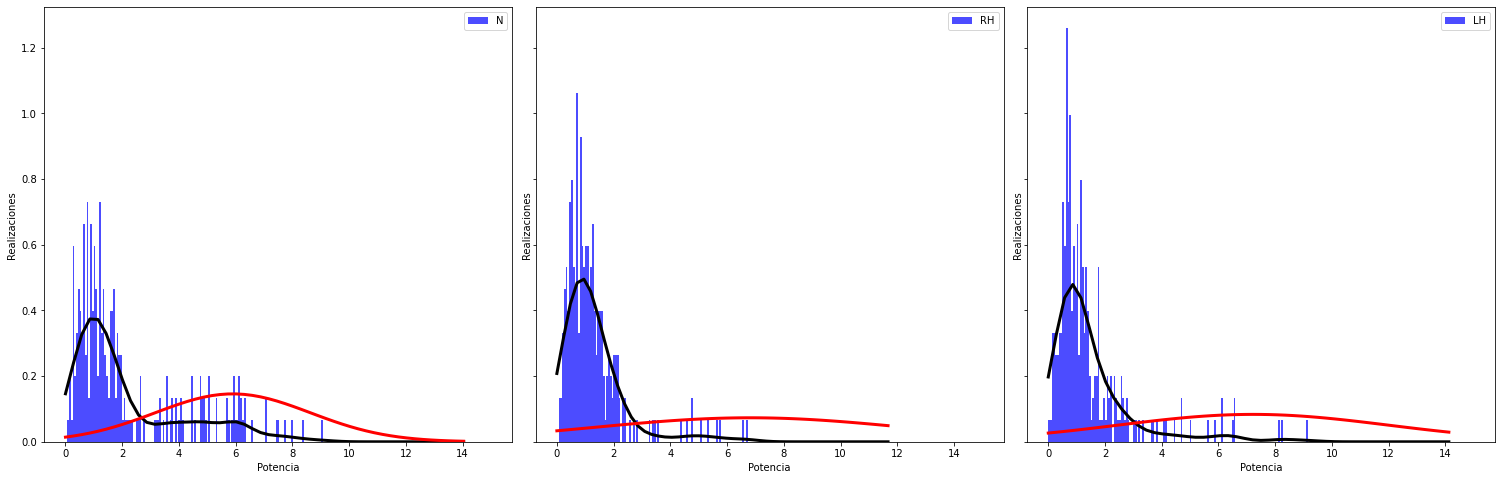

In [ ]:
density_param = {'density': True}
freq=7
#Se obtienen los datos de training y test de cada uno de los estimulos
trainingData_N,testData_N=getData('N','Fp1',freq)
trainingData_RH,testData_RH=getData('RH','Fp1',freq)
trainingData_LH,testData_LH=getData('LH','Fp1',freq)

trainingData_N=trainingData_N[:, np.newaxis]
trainingData_RH=trainingData_RH[:, np.newaxis]
trainingData_LH=trainingData_LH[:, np.newaxis]
testData_N=testData_N[:, np.newaxis]
testData_RH=testData_RH[:, np.newaxis]
testData_LH=testData_LH[:, np.newaxis]
testData=[testData_N,testData_RH,testData_LH]


trainLength=len(trainingData_N)
testLenght=len(testData_N)

bins = np.linspace(0,15, len(trainingData_N))

fig = plt.figure()
fig, ax = plt.subplots(1, 3,figsize=(26,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)


#Histograma de los datos
ax[0].hist(trainingData_N,bins=bins,**density_param, alpha=.7,facecolor='blue', label='N')
ax[1].hist(trainingData_RH,bins=bins,**density_param, alpha=.7,facecolor='blue', label='RH')
ax[2].hist(trainingData_LH,bins=bins,**density_param, alpha=.7,facecolor='blue', label='LH')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_xlabel('Potencia')
ax[1].set_xlabel('Potencia')
ax[2].set_xlabel('Potencia')
ax[0].set_ylabel('Realizaciones')
ax[1].set_ylabel('Realizaciones')
ax[2].set_ylabel('Realizaciones')


#Modelos
kde_N  = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(trainingData_N)
kde_RH = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(trainingData_RH)
kde_LH = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(trainingData_LH)
estimators=[kde_N,kde_RH,kde_LH]

#Graficar el modelo
grid_N  = np.linspace(0, np.max(trainingData_N)+5)[:, np.newaxis]
grid_RH = np.linspace(0, np.max(trainingData_RH)+5)[:, np.newaxis]
grid_LH = np.linspace(0, np.max(trainingData_LH)+5)[:, np.newaxis]

logDens_N  = kde_N.score_samples(grid_N)
logDens_RH = kde_RH.score_samples(grid_RH)
logDens_LH = kde_LH.score_samples(grid_LH)

ax[0].plot(grid_N,  np.exp(logDens_N),color='black',linewidth=3)
ax[1].plot(grid_RH, np.exp(logDens_RH),color='black',linewidth=3)
ax[2].plot(grid_LH, np.exp(logDens_LH),color='black',linewidth=3)


hits=0
p=[0,0,0]
Phits=[0,0,0]
for d in range(0,testLenght):
  for est in range(0,3):
    for k in range(0,3):
      data=testData[k][d]
      p[k]=np.exp(estimators[est].score_samples([data]))[0]
    ind=p.index(np.max(p))
    #print(p,est)
    if ind==est:
      hits=hits+1
      Phits[est]=Phits[est]+1

#Pt=hits/testLenght
#print('KDE')
#print(Pt)



data,labels=Data('Fp1',6)
X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=0.2, random_state=0)
clf=GaussianClassifier()
clf.train(X_train,y_train)
predictions=clf.predict(X_train)
print('Gaussian Classifier')
print(clf.accuracy(predictions,y_train))


ax[0].plot(grid_N, clf.prob_N.pdf(grid_N),color='red',linewidth=3)
ax[1].plot(grid_RH, clf.prob_RH.pdf(grid_RH),color='red',linewidth=3)
ax[2].plot(grid_LH, clf.prob_LH.pdf(grid_LH),color='red',linewidth=3)


Finalmente, se prueban los modelos con los datos de test y se obtiene el porcentaje de precisión del modelo. 

Como se puede ver, el porcentaje de precisión del modelo es de apenas 55%. Es posible que este porcentaje pueda mejorar si se incluyen más datos de entrenamiento, o bien, utilizando otras caracteristicas de los datos, por ejemplo.
Sin embargo, se puede concluir que este modelo no es funcional para resolver el problema de clasificación. 